In [10]:
%%capture
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import pandas as pd

from tensorflow.keras import layers, optimizers
from collections import deque
from matplotlib.ticker import MaxNLocator

SEED = 111

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [16]:
# DATASET = 'mnist'
DATASET = 'cifar10'

if DATASET == 'mnist':
    DATASET_PARAMS = dict(
        input_shape=(28, 28, 3),
        n_classes=10,
        baseline_accuracy=.3,
        n_layers=2
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:20%]', 'train[80%:]'],
        as_supervised=True
    )

    gray_to_rgb = lambda image, label: (tf.repeat(image, 3, axis=-1), label)
    train_ds = train_ds.map(gray_to_rgb)
    val_ds = val_ds.map(gray_to_rgb)
elif DATASET == 'cifar10':
    DATASET_PARAMS = dict(
        input_shape=(32, 32, 3),
        n_classes=10,
        baseline_accuracy=.1,
        n_layers=3
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:10%]', 'train[90%:]'],
        as_supervised=True
    )

# next(train_ds.as_numpy_iterator())[0].shape
# gray_item, rgb_item = next(train_ds.as_numpy_iterator()), next(ds.as_numpy_iterator())
# gray_image, rgb_image = gray_item[0], rgb_item[0]
# gray_image[row][col], rgb_image[row][col]

# (image,_), (rgb_item,_) = next(train_ds.as_numpy_iterator()), next(ds.as_numpy_iterator())

# gray_item

2022-10-13 14:20:46.379058: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(32, 32, 3)

In [17]:
CHILD_PARAMS = dict(
    epochs=1,
    batch_size=128,
    learning_rate=0.001,
    train_ds=train_ds,
    val_ds=val_ds,
    rolling_accuracies_window=20,
)

class ChildManager():
    def __init__(self):
        self.tds = CHILD_PARAMS['train_ds'].shuffle(
            500,
            reshuffle_each_iteration=True
        ).batch(CHILD_PARAMS['batch_size'])
        self.vds = CHILD_PARAMS['val_ds'].batch(256)

        self.past_accuracies = deque(maxlen=CHILD_PARAMS['rolling_accuracies_window'])
        self.past_accuracies.append(DATASET_PARAMS['baseline_accuracy'])

    def make_child(self, config):
        """
        Arguments:
            config: It is an ordered list of tuples.
                    Each tuple contains configuration for constructing a CNN layer.

        Returns:
            model: A CNN model with the layers laid out based on the input config.
        """
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.float32))

        for idx, (channels, kernel) in enumerate(config):
            model.add(layers.Conv2D(channels, kernel, name='conv_%d'%(idx)))
            model.add(layers.MaxPool2D(2))
            model.add(layers.Activation('relu'))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(DATASET_PARAMS['n_classes'], activation='softmax'))

        optimizer = optimizers.Adam(learning_rate=CHILD_PARAMS['learning_rate'])
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics='accuracy'
        )

        return model
    
    def train(self, model):
        history = model.fit(self.tds, validation_data=self.vds, epochs=CHILD_PARAMS['epochs'])
        accuracy = max(history.history['val_accuracy'])

        return accuracy
    
    def get_rewards(self, config):
        model = self.make_child(config)
        accuracy = self.train(model)

        self.past_accuracies.append(accuracy)
        rolling_accuracy = (sum(self.past_accuracies)/len(self.past_accuracies))
        reward = accuracy - rolling_accuracy

        return reward, accuracy

STATE_SPACE = [
    dict(name='channels', values=[16, 32, 64]),
    dict(name='kernel', values=[1, 3]),
]

CONTROLLER_PARAMS = dict(
    exploration=0.8,
    hidden_size=32,
    episodes=5,
    learning_rate=0.001
)

def convert_controller_preds_to_child_config(predictions):
    channels_ids = map(lambda x: predictions[2*x], range(DATASET_PARAMS['n_layers']))
    kernel_ids = map(lambda x: predictions[2*x+1], range(DATASET_PARAMS['n_layers']))

    channels = map(lambda x: STATE_SPACE[0]['values'][x], channels_ids)
    kernel = map(lambda x: STATE_SPACE[1]['values'][x], kernel_ids)

    return list(zip(channels, kernel))

class Controller():
    def __init__(self):
        self.rnn = self.make_rnn()
        self.store = dict(children=[], rewards=[], accuracies=[])
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        self.optimizer = optimizers.Adam(
            learning_rate=CONTROLLER_PARAMS['learning_rate']
        )

    def make_rnn(self):
        start_state = tf.keras.Input(shape=(), dtype=tf.int32)
        rnn_cell = tfa.rnn.NASCell(CONTROLLER_PARAMS['hidden_size'])

        initial_data = {
            'cell_state': [
                tf.zeros((1, CONTROLLER_PARAMS['hidden_size']), dtype=tf.float32),
                tf.zeros((1, CONTROLLER_PARAMS['hidden_size']), dtype=tf.float32)
            ],
            'embeddings': tf.keras.layers.Embedding(
                len(STATE_SPACE[0]['values']),
                CONTROLLER_PARAMS['hidden_size']
            )
        }

        prev_output = initial_data['embeddings'](start_state)
        prev_cell_state = initial_data['cell_state']
        predictions = []

        for action_id in range(len(STATE_SPACE)*DATASET_PARAMS['n_layers']):
            prev_output, prev_cell_state = rnn_cell(prev_output, prev_cell_state)
            state_id = action_id%len(STATE_SPACE)
            prediction_layer = tf.keras.layers.Dense(len(STATE_SPACE[state_id]['values']), activation='softmax')
            pred_action = prediction_layer(prev_output)
            predictions.append(pred_action)

        model = tf.keras.Model(inputs=start_state, outputs=predictions)
        model.summary()

        return model
    
    def predict_child(self, start_state):
        if np.random.random() < CONTROLLER_PARAMS['exploration']:
            predictions = list(map(
                lambda x: random.randrange(len(STATE_SPACE[x%len(STATE_SPACE)]['values'])),
                range(len(STATE_SPACE)*DATASET_PARAMS['n_layers'])
            ))
            print('Random Predictions:', predictions)
        else:
            predictions = self.rnn([start_state])
            predictions = list(map(lambda x: np.argmax(x), predictions))

        return predictions
    
    def save_trial(self, child, reward, accuracy):
        self.store['children'].append(child)
        self.store['rewards'].append(reward)
        self.store['accuracies'].append(accuracy)
    
    def train_step(self):
        child_config = self.store['children'][-1]
        reward = self.store['rewards'][-1]
        start_state = np.array([child_config[0]])

        with tf.GradientTape() as tape:
            outputs = controller.rnn(start_state)
            loss = 0.

            for index, output in enumerate(outputs):
                y_true = [child_config[index]]
                loss += self.loss_fn(y_true, output)
            
            grads = tape.gradient(loss, controller.rnn.trainable_variables)
            
            for index, grad in enumerate(grads):
                grads[index] = tf.multiply(grad, reward)

            self.optimizer.apply_gradients(
                zip(grads, controller.rnn.trainable_variables)
            )

controller = Controller()
child_manager = ChildManager()
start_state = np.array([random.randrange(len(STATE_SPACE[0]))])

for episode in range(CONTROLLER_PARAMS['episodes']):
    predictions = controller.predict_child(start_state)
    config = convert_controller_preds_to_child_config(predictions)

    print('Episode: {} Child Config: {}'.format(episode, config))

    # Evaluate the child generated by the controller
    reward, accuracy = child_manager.get_rewards(config)
    print(
        'Episode: {} Reward: {} Accuracy: {}'.format(
            episode,
            reward,
            accuracy
        )
    )

    # Store predicted child and its rewards
    controller.save_trial(predictions, reward, accuracy)
    
    # Train the Controller
    controller.train_step()

    # Update start_state for next episode.
    start_state = np.array([predictions[0]])
    tf.print('Start State:', start_state)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 32)           96          ['input_19[0][0]']               
                                                                                                  
 nas_cell_3 (NASCell)           ((None, 32),         16384       ['embedding_3[0][0]',            
                                 [(None, 32),                     'nas_cell_3[0][0]',             
                                 (None, 32)])                     'nas_cell_3[0][1]',             
                                                                  'nas_cell_3[0][2]',       

2022-10-13 14:20:52.744103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 9.5759 - accuracy: 0.1104

2022-10-13 14:20:53.930705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 2s 38ms/step - loss: 9.5759 - accuracy: 0.1104 - val_loss: 2.3282 - val_accuracy: 0.1118
Episode: 0 Reward: 0.0059000037610530826 Accuracy: 0.11180000752210617
Start State: array([2])
Random Predictions: [0, 1, 0, 0, 2, 0]
Episode: 1 Child Config: [(16, 3), (16, 1), (64, 1)]
 1/40 [..............................] - ETA: 12s - loss: 27.3196 - accuracy: 0.1094

2022-10-13 14:20:54.736075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 9.1755 - accuracy: 0.1216

2022-10-13 14:20:55.526823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 21ms/step - loss: 9.1755 - accuracy: 0.1216 - val_loss: 4.2905 - val_accuracy: 0.1650
Episode: 1 Reward: 0.03940000186363857 Accuracy: 0.16500000655651093
Start State: array([0])
Random Predictions: [1, 1, 2, 1, 1, 1]
Episode: 2 Child Config: [(32, 3), (64, 3), (32, 3)]
 1/40 [..............................] - ETA: 12s - loss: 32.8968 - accuracy: 0.0625

2022-10-13 14:20:55.989630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 6.3261 - accuracy: 0.1346

2022-10-13 14:20:56.876262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 26ms/step - loss: 6.3261 - accuracy: 0.1346 - val_loss: 2.5394 - val_accuracy: 0.1722
Episode: 2 Reward: 0.03495000340044499 Accuracy: 0.172200009226799
Start State: array([1])
Random Predictions: [2, 0, 2, 0, 0, 0]
Episode: 3 Child Config: [(64, 1), (64, 1), (16, 1)]


2022-10-13 14:20:57.432200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 11.8864 - accuracy: 0.1134

2022-10-13 14:20:58.584635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 2s 34ms/step - loss: 11.8864 - accuracy: 0.1134 - val_loss: 2.3264 - val_accuracy: 0.0958
Episode: 3 Reward: -0.03316000074148179 Accuracy: 0.0958000048995018
Start State: array([2])
Random Predictions: [1, 1, 2, 0, 1, 0]
Episode: 4 Child Config: [(32, 3), (64, 1), (32, 1)]
 4/40 [==>...........................] - ETA: 0s - loss: 28.5645 - accuracy: 0.1191 

2022-10-13 14:20:59.258399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 9.1289 - accuracy: 0.1262

2022-10-13 14:21:00.128692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 26ms/step - loss: 9.1289 - accuracy: 0.1262 - val_loss: 3.2534 - val_accuracy: 0.1530
Episode: 4 Reward: 0.020033338665962214 Accuracy: 0.15300001204013824
Start State: array([1])


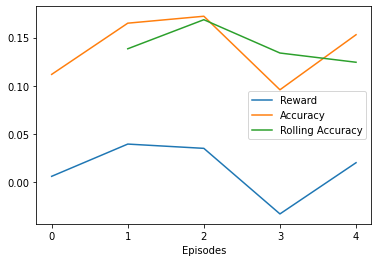

In [18]:
accuracies_df = pd.DataFrame(controller.store['accuracies'])
rolling_accuracies = accuracies_df.rolling(2).mean()[0].tolist()

plt.plot(controller.store['rewards'], label='Reward')
plt.plot(controller.store['accuracies'], label='Accuracy')
plt.plot(rolling_accuracies, label='Rolling Accuracy')
plt.xlabel('Episodes')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

In [20]:
child_configs = list(
    map(
        convert_controller_preds_to_child_config,
        controller.store['children']
    )
)
layer_id_to_name = lambda x: 'Layer %d'%x
columns = list(map(layer_id_to_name, range(DATASET_PARAMS['n_layers'])))
df = pd.DataFrame(child_configs, columns=columns)
df['Accuracy'] = controller.store['accuracies']
df.index.name = 'Episodes'

def column_summary(df, column):
    column_df = df[[column, 'Accuracy']].groupby(column)
    column_stats = column_df.mean()
    column_stats['Counts'] = column_df.count()
    return column_stats

display(df)
for layer_id in range(DATASET_PARAMS['n_layers']):
    display(column_summary(df, layer_id_to_name(layer_id)))

,Layer 0,Layer 1,Layer 2,Accuracy
Episodes,,,,
0,"(64, 1)","(32, 1)","(32, 3)",0.1118
1,"(16, 3)","(16, 1)","(64, 1)",0.1650
2,"(32, 3)","(64, 3)","(32, 3)",0.1722
3,"(64, 1)","(64, 1)","(16, 1)",0.0958
4,"(32, 3)","(64, 1)","(32, 1)",0.1530


,Accuracy,Counts
Layer 0,,
"(16, 3)",0.1650,1
"(32, 3)",0.1626,2
"(64, 1)",0.1038,2


,Accuracy,Counts
Layer 1,,
"(16, 1)",0.1650,1
"(32, 1)",0.1118,1
"(64, 1)",0.1244,2
"(64, 3)",0.1722,1


,Accuracy,Counts
Layer 2,,
"(16, 1)",0.0958,1
"(32, 1)",0.1530,1
"(32, 3)",0.1420,2
"(64, 1)",0.1650,1


(<AxesSubplot:xlabel='Episodes', ylabel='Accuracies'>, <AxesSubplot:>)

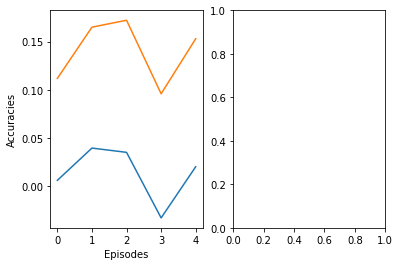

In [21]:
fig, axes = plt.subplots(1, 2)
plt_rewards, plt_accuracies = axes

plt_rewards.plot(controller.store['rewards'], label='Reward')
plt_rewards.set_xlabel('Episodes')
plt_rewards.set_ylabel('Rewards')

plt_rewards.plot(list(child_manager.past_accuracies)[1:], label='Accuracy')
plt_rewards.set_xlabel('Episodes')
plt_rewards.set_ylabel('Accuracies')

plt_rewards, plt_accuracies
# controller.store